In [1]:
from turning_scene import *
from l5kit.rasterization.rasterizer_builder import _load_metadata

D:\Anaconda\lib\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  "Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows."


In [84]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\prediction-dataset"
# get config
cfg = load_config_data("C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\Codes\\python codes\\visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)
# Obatin the information from semantic map

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [300, 300], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+------

In [79]:
class Trajectory(Scene):
    
    def __init__(self, dataset, Map_Api):
        super(Trajectory, self).__init__(dataset, Map_Api)
        self.label_name = ['Car','Van','Tram','Bus','Truck','EV','OV','Bicycle','Motorcycle','Cyclist','Motorcyclist','Pedestrian']
        self.label_idx = list(range(3,15))
        self.label_dict = dict(zip(self.label_name, self.label_idx))

    def label_loc_check(self, target_label):
    
        agent_id_list = self.agent_list[self.label_dict[target_label]-3]

        for agent_id in agent_id_list:
            agent_loc = self.agent_centroid[np.where(agent_id==agent_id)[0]]
            for centroid in agent_loc:
                if self.Junction_region.contains(Point(centroid[0],centroid[1])):
#                     print(agent_id)
                    return True
    
    def junction_lane_visualize(self, junction_id):
        
        plt.figure(figsize=(18,18))
        
        lane_list = self.Junction_Lane[junction_id]
        
        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,0].tolist(),
                        self.map_api.get_lane_coords(lane)['xyz_left'][:,1].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,1].tolist(),
                        marker='x', label = lane)

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20)
        axes = plt.gca()  
    
                
    def agent_trajectory(self, scene, target_label, junction, ego_dataset):

        self.scene = scene
        self.target_label = target_label
        self.junction = junction
        junction_boundary = {junction:[(300,-1150),[300,-1100],(340,-1100),(340,-1150)]}
        self.Junction_region = Polygon(junction_boundary[junction])

        self.agent_list = []
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        agent_interval_begin = self.dataset.frames[frame_interval[0]]['agent_index_interval'][0]
        agent_interval_end = self.dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
        self.agent_id = self.dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
        agent_label_prob = self.dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
        self.agent_centroid = self.dataset.agents[agent_interval_begin:agent_interval_end]['centroid']

        for label in self.label_idx:
            valid_idx = np.where(agent_label_prob[:,label]>0.5)[0]
            valid_id = set(self.agent_id[valid_idx])
            self.agent_list.append(list(valid_id))


        if len(self.agent_list[self.label_dict[target_label]-3])>0 and self.label_loc_check(target_label):
            # self.trajectory_junction_visualize(scene, junction, frame_interval, target_label, ego_dataset)
            return [scene]
        else:
            # print('Not feasible scene')
            return []
            
            
            
    def trajectory_junction_visualize(self, scene, junction, frame_interval, target_label, ego_dataset):
        
        plt.figure(figsize=(18,18))
        lane_list = ['F/RY','AcOB','N3wG']


        plt.plot(self.map_api.get_lane_coords(lane_list[0])['xyz_right'][:,0], self.map_api.get_lane_coords(lane_list[0])['xyz_right'][:,1],
                     label='Junction: '+junction, color='k',linewidth=5)
        for lane in lane_list[1:]:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_right'][:,0], self.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='k',linewidth=5)

        cmap = plt.get_cmap('gnuplot')    
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','maple','yellowgreen'] 

        for idx, agent_label in enumerate(self.agent_list):
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 30  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3:
                    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+self.label_name[idx], color=colors[idx], marker='*')

        ego_translation = self.frames[frame_interval[0]:frame_interval[1]]['ego_translation']
        plt.plot(ego_translation[:,0],ego_translation[:,1],label='Ego',color='k')
        turn = ' Left Turn' if ego_dataset[frame_interval[0]]['yaw']-ego_dataset[frame_interval[1]-1]['yaw'] < 0 else ' Right Turn'

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20,loc='best')
        plt.title('Trajectory : Scene '+str(scene)+turn, fontsize=30)
        axes = plt.gca()

In [80]:
Test = Trajectory(zarr_dataset, Map_Api)
Test.generate_info_from_MAP()

In [24]:
junction_scene = np.load('train_junction_scene.npy', allow_pickle=True).item()
target_junction = junction_scene['sGK1']

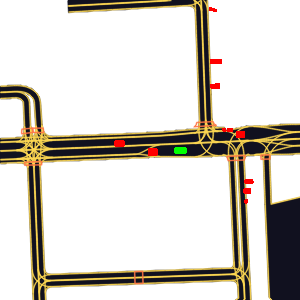

In [110]:
Test.scene_visualize(13861,ego_dataset,cfg)

# Find the scene index which are at the intersection: 'sGK1'

In [81]:
scene_pedestrian = []

for scene in tqdm(target_junction):
    scene_pedestrian += Test.agent_trajectory(scene, 'Pedestrian', 'sGK1', ego_dataset)
    
scene_pedestrian

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 463/463 [00:35<00:00, 13.14it/s]


[43,
 77,
 93,
 188,
 264,
 309,
 317,
 339,
 357,
 393,
 434,
 517,
 595,
 599,
 820,
 933,
 1176,
 1286,
 1652,
 1805,
 1966,
 2094,
 2163,
 2200,
 2286,
 2330,
 2436,
 2483,
 2541,
 2591,
 2615,
 2631,
 2681,
 2719,
 2846,
 2889,
 2958,
 3123,
 3184,
 3204,
 3251,
 3361,
 3376,
 3560,
 3619,
 3725,
 3926,
 3944,
 4045,
 4181,
 4330,
 4401,
 4482,
 4524,
 4538,
 4768,
 4817,
 5132,
 5199,
 5260,
 5296,
 5415,
 5634,
 5728,
 5790,
 5795,
 5811,
 5837,
 6082,
 6103,
 6140,
 6208,
 6319,
 6339,
 6344,
 6397,
 6461,
 6531,
 6590,
 6651,
 6681,
 6739,
 6779,
 6792,
 6847,
 7046,
 7144,
 7234,
 7286,
 7309,
 7494,
 7602,
 7694,
 7749,
 7877,
 7970,
 8178,
 8375,
 8532,
 8623,
 8677,
 8716,
 8727,
 8940,
 9124,
 9223,
 9285,
 9306,
 9397,
 9410,
 9560,
 9571,
 9759,
 9993,
 10032,
 10117,
 10626,
 10777,
 10837,
 10892,
 11086,
 11224,
 11239,
 11344,
 11392,
 11648,
 11800,
 11852,
 12046,
 12170,
 12218,
 12341,
 12382,
 12405,
 12442,
 12538,
 12761,
 12817,
 12831,
 12867,
 12968,
 1299

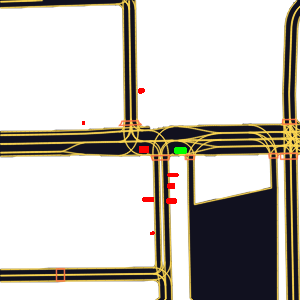

Current scene is  170
1668.1391432285309


In [96]:
import time


start = time.time()
for idx, valid_scene in enumerate(scene_pedestrian):
    Test.scene_visualize(valid_scene,ego_dataset,cfg)
    print('Current scene is ',idx)
    time.sleep(1)
    
end = time.time()
print(end-start)

In [104]:
invalid_scene_idx = [1,2,3,6,10,13,15,16,17,19,33,37,39,40,42,54,55,57,58,66,68,70,71,73,74,85,91,92,96,97,101,103,110,111,113,114,116,118,128,130,134,135,140,141,142,148,151,152,156,161,162,163,167,167,190]

In [107]:
target_scene_index = []
nontarget_scene_index = []
for index, value in enumerate(scene_pedestrian):
    
    if index in invalid_scene_idx:
        nontarget_scene_index.append(value)
    else:
        target_scene_index.append(value)

In [112]:
np.save('nontarget_scene_index.npy',nontarget_scene_index)